<a href="https://colab.research.google.com/github/bksgupta/course-v3/blob/master/lesson7_resnet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [5]:
path

PosixPath('/root/.fastai/data/mnist_png')

In [6]:
il = ImageList.from_folder(path, convert_mode='L')

In [7]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/0/16921.png')

In [8]:
defaults.cmap='binary'

In [9]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

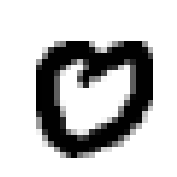

In [10]:
il[0].show()

In [11]:
sd = il.split_by_folder(train='training', valid='testing')

In [12]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [13]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/9')]

In [14]:
ll = sd.label_from_folder()

In [15]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /root/.fastai/data/mnist_png;

Test: None

In [16]:
x,y = ll.train[0]

0 torch.Size([1, 28, 28])


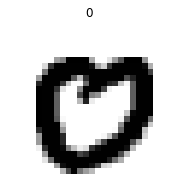

In [18]:
x.show(y=y)
print(y,x.shape)

In [19]:
x,y = ll.valid[0]

0 torch.Size([1, 28, 28])


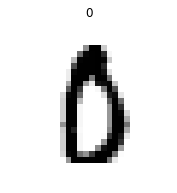

In [20]:
x.show(y=y)
print(y,x.shape)

In [21]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [22]:
ll = ll.transform(tfms)

In [23]:
bs = 128

In [24]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [25]:
x,y = data.train_ds[0]

0


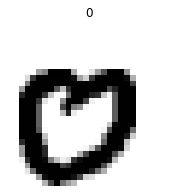

In [26]:
x.show(y=y)
print(y)

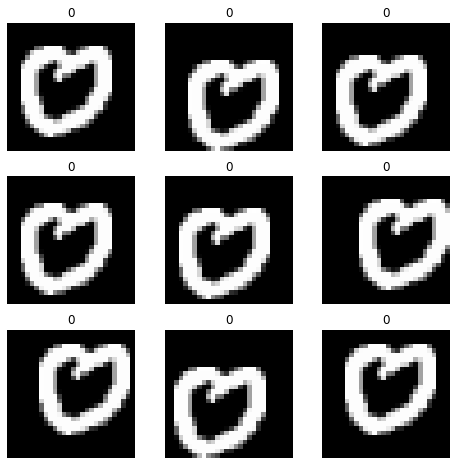

In [27]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray',y=y)
plot_multi(_plot, 3, 3, figsize=(8,8))

In [28]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

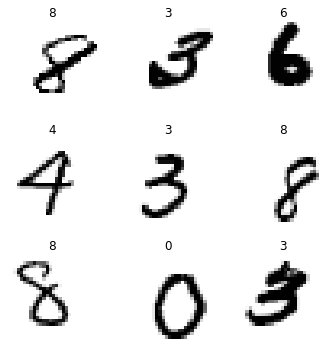

In [29]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [30]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [31]:
??nn.BatchNorm2d

In [32]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [33]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [34]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [36]:
xb = xb.cuda()

In [37]:
model(xb).shape

torch.Size([128, 10])

In [38]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


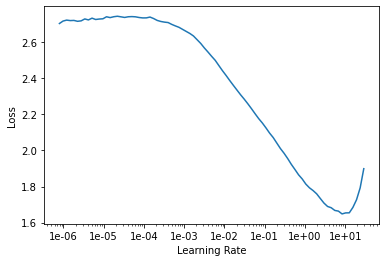

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.216171,0.248955,0.921400,00:25
1,0.128121,0.103982,0.966500,00:25
2,0.069355,0.037704,0.988900,00:25


### Refactor

In [41]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [42]:
??conv_layer()

In [43]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [44]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [45]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.229624,0.134261,0.957900,00:25
1,0.187115,0.169076,0.949100,00:24
2,0.153749,0.241798,0.926800,00:25
3,0.139362,0.085708,0.974600,00:25
4,0.108956,0.077307,0.977500,00:25
5,0.096487,0.058145,0.981900,00:25
6,0.077092,0.061148,0.980700,00:25
7,0.062621,0.038071,0.988200,00:25
8,0.048511,0.030036,0.990700,00:25
9,0.046114,0.027462,0.991000,00:25


### Resnet-ish

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [46]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [47]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [48]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [59]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    # conv_and_res(16,10),

    Flatten()
)

In [60]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


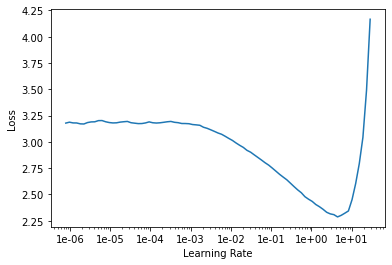

In [61]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.220529,0.193321,0.939700,00:28
1,0.136114,0.145507,0.957000,00:29
2,0.118109,0.062470,0.980700,00:28
3,0.085551,0.076361,0.976400,00:28
4,0.065682,0.049680,0.983500,00:28
5,0.059322,0.062246,0.982600,00:29
6,0.053627,0.055041,0.982800,00:28
7,0.043348,0.027399,0.991200,00:28
8,0.034711,0.028537,0.991500,00:29
9,0.027238,0.019618,0.993600,00:29


In [ ]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## fin